# teex

### Generating image data with g.t. saliency maps

Let's explore the 'seneca' method for generating artificial images with available ground truth saliency maps. It was presented in [Evaluating local explanation methods on ground truth, Riccardo Guidotti, 2021](https://www.researchgate.net/publication/346916247_Evaluating_local_explanation_methods_on_ground_truth), and although the original intention of the paper was not to present an artificial data generator, it can serve our purpose.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import teex

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from math import floor

#### 1. Generating synthetic images

Let's generate artificial image data with the 'seneca' method. In this case, the generated images are composed of squared cells of a fixed size and randomly colored as (almost) Red, Green or Blue. A number of these images contain a randomly generated pattern such that the ones that do so are labeled as '1' and the ones that are not are labeled as '0'. If an image contains the pattern, then the ground truth explanation is a binary mask of the same dimensions where the pattern is highlighted. The user can control: 

- Image width and height, in pixels
- Image cell width and height, in pixels and divisor of image width and height
- The proportion of the image that should be filled with cells (fillPct)
- Pattern height and width, in pixels. The number of pixels the randomly generated pattern will take (divisor of image width and height). The previous parameter 'fillPct' also specifies the number of cells filled in the pattern.
- The percentage of images that contain the pattern 'patternProp'
- colorDev: [0, 0.5] If 0, each cell will be completely red, green or blue. The greater (max 0.5), the more mixed will colored channels be. Adds complexity to the task of classification.

In [3]:
from teex.saliencyMap.data import SenecaSM

nSamples = 100
randomState = 8
imageH, imageW = 32, 32
patternH, patternW = 16, 16
cellH, cellW = 4, 4
patternProp = 0.5
fillPct = 0.4
colorDev = 0.1

dataGen = SenecaSM(nSamples=nSamples, imageH=imageH, imageW=imageW, 
                         patternH=patternH, patternW=patternW,
                         cellH=cellH, cellW=cellW, patternProp=patternProp, 
                         fillPct=fillPct, colorDev=colorDev, randomState=randomState)

X, y, exps = dataGen[:]
pat = dataGen.pattern

**X** contains the generated images, **y** the labels, **exps** the ground truth explanations and **pat** the exact pattern contained by the images.

#### Exploring the images

Some of the generated images contain the following pattern:

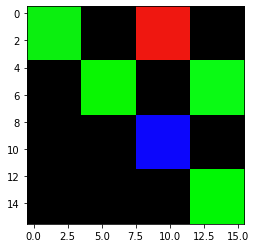

In [4]:
plt.imshow(pat)

For example, the first one, which is labeled as

1


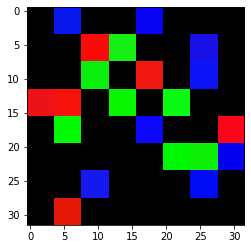

In [5]:
print(y[0])
plt.imshow(X[0])

contains it

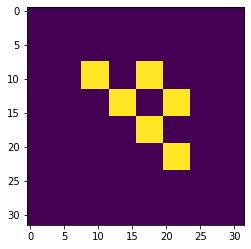

In [6]:
plt.imshow(exps[0])

for a more clear view:

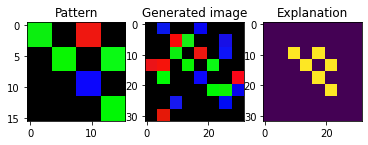

In [7]:
def plt_imgs(p, img, exp):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(p)
    axs[0].set_title('Pattern')
    axs[1].imshow(img)
    axs[1].set_title('Generated image')
    axs[2].imshow(exp)
    axs[2].set_title('Explanation')
    
plt_imgs(pat, X[0], exps[0])

Not all images have the pattern in the same position:

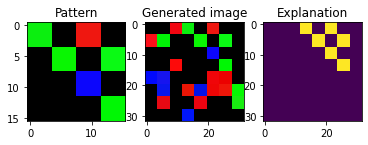

In [8]:
plt_imgs(pat, X[6], exps[6])

We can generate images with another pattern by changing the random state

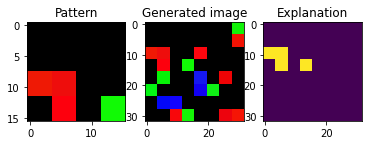

In [10]:
dataGen = SenecaSM(nSamples=100, imageH=imageH, imageW=imageW, 
                  patternH=patternH, patternW=patternW,
                  cellH=cellH, cellW=cellW, patternProp=patternProp, 
                  fillPct=fillPct, colorDev=colorDev, randomState=7)

X, y, exps = dataGen[:]
pat = dataGen.pattern

plt_imgs(pat, X[1], exps[1])

The images that do not contain a pattern have as explanation a black mask. Note that in order for the images to contain the pattern it must not only match the shape, but its colors too. We can check that we have the desired proportion of classes in the dataset:

In [11]:
sum(y) / len(y) == patternProp

True

We can also check how changing the parameter colorDev affects the coloring of the images

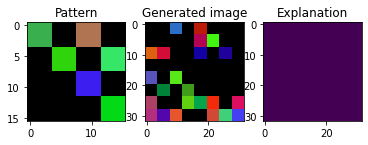

In [12]:
dataGen = SenecaSM(nSamples=nSamples, imageH=imageH, imageW=imageW, 
                  patternH=patternH, patternW=patternW,
                  cellH=cellH, cellW=cellW, patternProp=patternProp, 
                  fillPct=fillPct, colorDev=0.5, randomState=randomState)

X, y, exps = dataGen[:]
pat = dataGen.pattern

plt_imgs(pat, X[1], exps[1])

Indeed, the pattern and the cells that are filled in the images are the same, but the colors are different.

#### 2. Exploring a white-box model

The 'seneca' method used to generate the artificial data in TAIAOexp can also return an underlying white-box model. In the case of the image data, the model can recognize if the generated pattern is contained within an observation by performing a linear scan. The models implement .fit, .predict and .predict_proba methods in order for them to easily work with explainability frameworks. We can retrieve the whitebox model by setting the parameter 'returnModel' to **True** when generating the data.

In [13]:
dataGen = SenecaSM(nSamples=100, imageH=imageH, imageW=imageW, 
                   patternH=patternH, patternW=patternW,
                   cellH=cellH, cellW=cellW, patternProp=patternProp, 
                   fillPct=fillPct, colorDev=0.5, randomState=7)

X, y, exps = dataGen[:]
pat = dataGen.pattern
model = dataGen.transparentModel  # the underlying transparent model

In [14]:
model

In [15]:
model.predict(X[:5])

[1, 1, 0, 0, 0]

In [16]:
model.predict_proba(X[:5])

[[0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]

The model can also 'explain' instances dynamically:

Text(0.5, 1.0, 'Corresponding image')

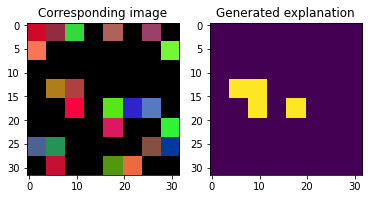

In [17]:
explanations = model.explain(X[:2])

fig, axs = plt.subplots(1, 2)
axs[1].imshow(explanations[0])
axs[1].set_title('Generated explanation')
axs[0].imshow(X[0])
axs[0].set_title('Corresponding image')

#### 3. Loading Kahikata image data

teex includes real datasets with available ground truth explanations. For example, the Kahikatea dataset contains 519 images, and the task is to tell whether each observation contains Kahikatea trees or not. There are 232 positive observations and 287 negative ones.

In teex, the non-artificial datasets are implemented as classes, similarly to PyTorch. After instancing the class, the data itself will be downloaded if it has not been used before. Once done, one can slice it to obtain observations. Each observation contains the data point, the label and the ground truth explanation.

In [ ]:
from teex.saliencyMap.data import Kahikatea

kahikateaData = Kahikatea()
kData, kLabels, kExps = kahikateaData[:]

Text(0.5, 1.0, 'g.t. explanation')

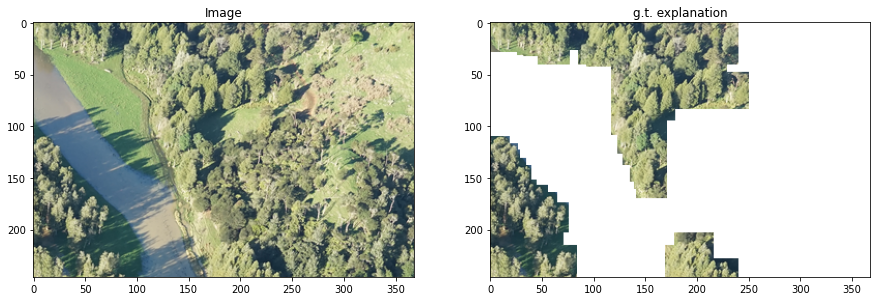

In [21]:
i = 0
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(kData[i])
axs[0].set_title('Image')
axs[1].imshow(kExps[i])
axs[1].set_title('g.t. explanation')

<p float="left">
  <img src="https://taiao.ai/img/6825_TAIAO_logo_1000x320.jpg" alt="drawing" style="width:150px;"/>
  <img src="https://www.bourses-etudiants.ma/wp-content/uploads/2018/06/University-of-Waikato-logo.png" alt="drawing" style="width:150px;"/>
  <img src="https://www.upc.edu/comunicacio/ca/identitat/descarrega-arxius-grafics/fitxers-marca-principal/upc-positiu-p3005.png" alt="drawing" style="width:200px;"/>
</p>